In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import h5py
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Here we are importing the h5 file and create a dataframe.

In [2]:
file = h5py.File('Data_Fuchs_v_2.7_Wright_Pat_Narrow_Range_energy_limit_0.01_deviation_0.0_lambda_um_0.8_points_100000_seed_3.h5','r')
file_dict = dict()
for i in file.keys():
    file_dict[i] = file[i][:]
file.close()
physics = pd.DataFrame(file_dict)

# Here we specify the input and output variables

In [3]:
outputs = ['Max_Proton_Energy_(MeV)', 'Total_Proton_Energy_(MeV)', 'Avg_Proton_Energy_(MeV)']

In [4]:
# this is to avoid copying a pasting
inputs = []
for i in physics.columns:
    if i in outputs:
        continue
    else:
        inputs.append(i)
inputs

['Intensity_(W_cm2)',
 'Pulse_Duration_(fs)',
 'Spot_Size_(FWHM um)',
 'Target_Thickness (um)']

##### For now, we will work with a dataframe that only has Max Proton Energy as the output variable and name it df.

In [5]:
df = physics.copy()
df = df.drop(columns= outputs[1:])
df.columns

Index(['Intensity_(W_cm2)', 'Max_Proton_Energy_(MeV)', 'Pulse_Duration_(fs)',
       'Spot_Size_(FWHM um)', 'Target_Thickness (um)'],
      dtype='object')

##### The train and split sets will also be created here for df.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df[[inputs[0], inputs[3]]], df[outputs[0]], test_size=0.33, random_state=0)

##### Normalizing the data

In [7]:
X_train_means = X_train.mean()
X_train_stds = X_train.std(ddof=1)
X_train_norm = (X_train - X_train_means) / X_train_stds

y_train_means = y_train.mean()
y_train_stds = y_train.std(ddof=1)
y_train_norm = (y_train - y_train_means) / y_train_stds

X_test_means = X_test.mean()
X_test_stds = X_test.std(ddof=1)
X_test_norm = (X_test - X_test_means) / X_test_stds

y_test_means = y_test.mean()
y_test_stds = y_test.std(ddof=1)
y_test_norm = (y_test - y_test_means) / y_test_stds

In [8]:
X_train_norm.head()

,Intensity_(W_cm2),Target_Thickness (um)
32684,-0.164531,1.047151
77206,-1.200541,0.306467
17196,-0.065437,0.991962
94613,0.479241,1.291706
61769,-0.376358,-1.637519


# Scatter plot of the data to be modeled.

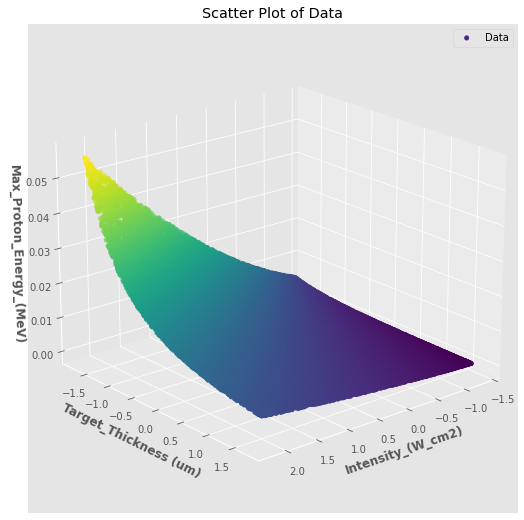

In [9]:
fig1 = plt.figure(figsize=(9, 9))
ax = fig1.add_subplot(projection='3d')
ax.scatter(X_train_norm[inputs[0]],
           X_train_norm[inputs[3]],
           y_train,
           c = np.sqrt(y_train),
           label = "Data")
ax.set_title('Scatter Plot of Data')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[0]}', fontweight ='bold')
ax.view_init(20, 50)
plt.legend(loc="upper right")
plt.show()

# Support Vector Regression model (SVR)

##### First we create a model to predict the values of the X test set to see what the predictions look like.

In [10]:
start_time = time.process_time()

In [11]:
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.03, coef0=.5)

In [12]:
svr_poly.fit(X_train_norm[[inputs[0], inputs[3]]], np.log(y_train))

SVR(C=100, coef0=0.5, epsilon=0.03, gamma='auto', kernel='poly')

In [13]:
np.exp(svr_poly.predict(X_train_norm))

array([0.00206816, 0.00098573, 0.00229386, ..., 0.00473797, 0.011213  ,
       0.00056282])

##### CPU time to run, train, and predict data

In [14]:
end_time = time.process_time()
print(f'The CPU time for this model to run is {end_time - start_time} seconds.')
del start_time
del end_time

The CPU time for this model to run is 1.2867760000000006 seconds.


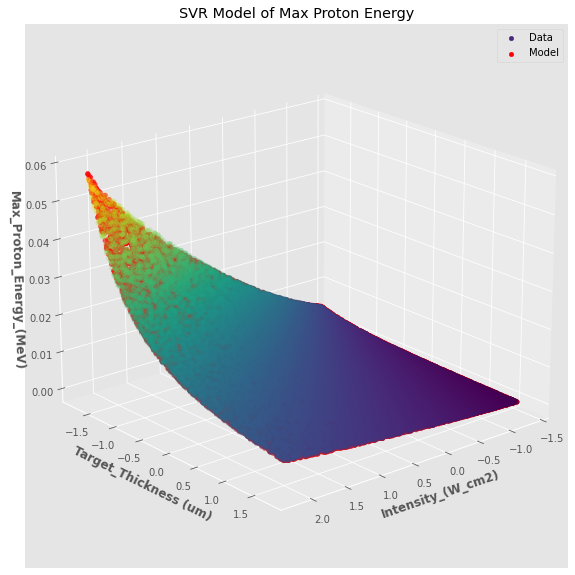

In [15]:
fig2 = plt.figure(figsize=(10, 10))
ax = fig2.add_subplot(projection='3d')
ax.scatter(X_train_norm[inputs[0]],
           X_train_norm[inputs[3]],
           y_train ,
           c = np.sqrt(y_train),
           alpha = .2,
           label= 'Data')
ax.scatter(X_train_norm[inputs[0]],
           X_train_norm[inputs[3]],
           np.exp(svr_poly.predict(X_train_norm)),
           c = 'red',
           alpha= .6,
           label= 'Model')
ax.set_title('SVR Model of Max Proton Energy')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[0]}', fontweight ='bold')
ax.view_init(20, 50)
plt.legend(loc="upper right")
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_alpha(1)
leg.legendHandles[0].set_alpha(1)
plt.show()

##### An error dataframe will be created for the log transformed data model for the testing sets. This dataframe will also contain the predicted values of the log model, and it will contain the predicted values of the model converted back into its original non log format.

In [16]:
error_3d = X_test_norm.copy()
error_3d['Predictions'] = np.exp(svr_poly.predict(X_test_norm))
error_3d['Relative Error'] = np.abs((y_test - error_3d['Predictions']) / y_test) * 100

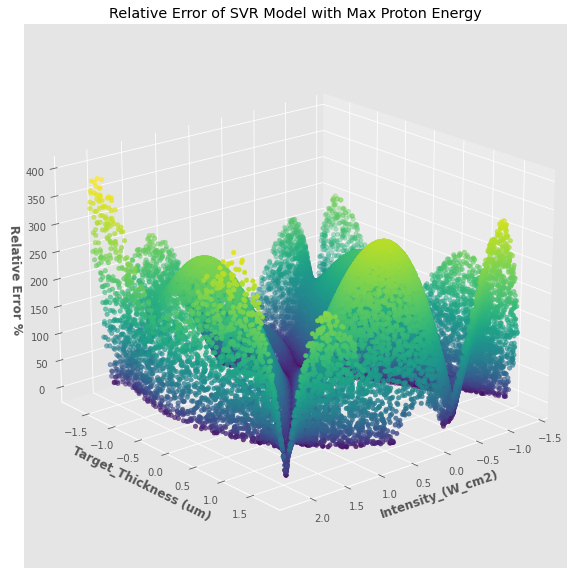

In [17]:
fig3 = plt.figure(figsize=(10, 10))
ax = fig3.add_subplot(projection='3d')
ax.scatter(X_test_norm[inputs[0]],
           X_test_norm[inputs[3]],
           error_3d['Relative Error'] * 100,
           c = np.sqrt(error_3d['Relative Error']))
ax.set_title('Relative Error of SVR Model with Max Proton Energy')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'Relative Error %', fontweight ='bold')
ax.view_init(20, 50)
plt.show()

In [18]:
mean_squared_error(y_test, error_3d['Predictions'])

2.07462202702122e-08